## `Forecasting County-Level Acute Food Insecurity in Kenya Using Climate Shocks, Market Dynamics, Conflict Events, and Structural Poverty Indicators`

## `1. Business Understanding`

### `1.1 Problem Context`


Acute food insecurity remains a recurring challenge in Kenya, particularly in arid and semi-arid counties. Current Integrated Food Security Phase Classification (IPC) assessments provide detailed descriptions of food security conditions but are largely retrospective. As a result, humanitarian interventions are often reactive rather than anticipatory.

There is a need for a data-driven early warning system that can forecast which counties are likely to enter IPC Phase 3 (Crisis) or worse in the near future.


### `1.2 Project Objective`

To develop a spatio-temporal machine learning model that predicts whether a Kenyan county will experience acute food insecurity `(IPC ≥ 3)` in the following month, using:

- Climate indicators (rainfall anomalies)

- Market indicators (food prices)

- Conflict events

- Structural vulnerability (MPI)


### `1.3 Business Value`

The model supports:

- Humanitarian agencies (WFP, FAO, NGOs)

- County governments

- National drought management authorities

- Policy planners


By forecasting crisis risk early, stakeholders can:

- Prioritize resource allocation

- Trigger anticipatory action

- Improve efficiency of emergency response

### `2. Data Understanding`

The project uses five datasets:

### `2.1 IPC Dataset (Target Variable)`

Purpose: Defines food insecurity classification.

Key Variable:

IPC Phase (1–5)

Target Definition:

Binary target:
1 → IPC ≥ 3 (Crisis or worse)
0 → IPC < 3

Time Structure:

County-level

Periodic assessments

Role:

Supervised learning target (shifted to t+1 for forecasting)


### `2.2 Rainfall Dataset`

Purpose: Captures climate shocks.

Key Variables:

Monthly rainfall

Rainfall anomaly

Role:

Predictor of agricultural stress

Lagged effects (t-1, t-2)


### `2.3 Food Prices Dataset (WFP)`

Purpose: Captures market stress.

Key Variables:

Commodity

USD price

Market location

Date

Processing:

Aggregated to county-month

Staple price index constructed

Monthly price change computed

Role:

Short-term shock indicator


### `2.4 Conflict Dataset`

Purpose: Captures instability and displacement risk.

Key Variables:

Monthly events

Fatalities

Processing:

Aggregated to county-month

Rolling 3-month conflict intensity

Role:

Disruption and vulnerability driver


### `2.5 MPI Dataset (Structural Poverty)`

Purpose: Captures long-term vulnerability.

Key Variables:

Multidimensional Poverty Index score

Possibly deprivation indicators

Role:

Static vulnerability factor

Moderates shock effects

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date handling
from datetime import datetime

# Warnings
import warnings
warnings.filterwarnings("ignore")

# For geospatial (later)
# import geopandas as gpd

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# IPC dataset
ipc = pd.read_csv("../data/ipc_ken_area_long.csv")

# Rainfall dataset
rain = pd.read_csv("../data/ken-rainfall-subnat-full.csv")

# Conflict dataset
conflict = pd.read_excel("../data/kenya_political_violence_events_and_fatalities_by_month-year_as-of-11feb2026.xlsx")

# MPI dataset
mpi = pd.read_csv("../data/ken_mpi.csv")

# Food Prices dataset
prices = pd.read_csv("../data/wfp_food_prices_ken.csv")

print("All datasets loaded.")


All datasets loaded.


In [3]:
ipc.head()

,Date of analysis,Country,Total country population,Level 1,Area,Validity period,From,To,Phase,Number,Percentage
0,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,all,515000,1.00
1,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,3+,103000,0.20
2,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,1,128750,0.25
3,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,2,283250,0.55
4,Jul 2025,KEN,16617000,Others,Marsabit,current,2025-07-01,2025-09-30,3,103000,0.20


### IPC TARGET PREPARATION

In [4]:
# 1️⃣ Ensure date columns are datetime
ipc['From'] = pd.to_datetime(ipc['From'])
ipc['To'] = pd.to_datetime(ipc['To'])

# 2️⃣ Optional: Filter only "current" validity period (recommended)
ipc_current = ipc[ipc['Validity period'] == 'current'].copy()

# 3️⃣ Pivot phases into columns
ipc_pivot = ipc_current.pivot_table(
    index=['Area', 'From'],
    columns='Phase',
    values='Percentage',
    aggfunc='sum'  # Safe aggregation
).reset_index()

# 4️⃣ Clean column names
ipc_pivot.columns.name = None  # remove multi-index name

# 5️⃣ Ensure Phase '3+' exists
if '3+' not in ipc_pivot.columns:
    raise ValueError("Phase 3+ not found in dataset!")

# 6️⃣ Create Regression Target (continuous)
ipc_pivot['target_ipc3plus_pct'] = ipc_pivot['3+']

# 7️⃣ Create Classification Target (binary)
# Threshold can be adjusted (0.20 = 20% population in crisis)
ipc_pivot['target_crisis_binary'] = (
    ipc_pivot['target_ipc3plus_pct'] > 0.20
).astype(int)


print("\nIPC Pivot Shape:", ipc_pivot.shape)
print("\nColumns:", ipc_pivot.columns.tolist())

print("\nIPC 3+ Summary:")
print(ipc_pivot['target_ipc3plus_pct'].describe())

print("\nBinary Target Distribution:")
print(ipc_pivot['target_crisis_binary'].value_counts())

print("\nSample Data:")
print(ipc_pivot.head())


IPC Pivot Shape: (323, 11)

Columns: ['Area', 'From', '1', '2', '3', '3+', '4', '5', 'all', 'target_ipc3plus_pct', 'target_crisis_binary']

IPC 3+ Summary:
count    323.000000
mean       0.152012
std        0.133586
min        0.000000
25%        0.050000
50%        0.100000
75%        0.200000
max        0.550000
Name: target_ipc3plus_pct, dtype: float64

Binary Target Distribution:
target_crisis_binary
0    255
1     68
Name: count, dtype: int64

Sample Data:
         Area       From     1     2     3    3+     4    5  all  \
0  BANGLADESH 2020-08-01  0.10  0.35  0.45  0.55  0.10  0.0  1.0   
1     Baringo 2019-07-01  0.35  0.50  0.10  0.15  0.05  0.0  1.0   
2     Baringo 2020-02-01  0.70  0.25  0.05  0.05  0.00  0.0  1.0   
3     Baringo 2020-08-01  0.80  0.15  0.05  0.05  0.00  0.0  1.0   
4     Baringo 2021-02-01  0.60  0.30  0.10  0.10  0.00  0.0  1.0   

   target_ipc3plus_pct  target_crisis_binary  
0                 0.55                     1  
1                 0.15        

In [5]:
ipc_pivot = ipc_pivot.drop(ipc_pivot.index[0] )
ipc_pivot.head()

,Area,From,1,2,3,3+,4,5,all,target_ipc3plus_pct,target_crisis_binary
1,Baringo,2019-07-01,0.35,0.50,0.10,0.15,0.05,0.0,1.0,0.15,0
2,Baringo,2020-02-01,0.70,0.25,0.05,0.05,0.00,0.0,1.0,0.05,0
3,Baringo,2020-08-01,0.80,0.15,0.05,0.05,0.00,0.0,1.0,0.05,0
4,Baringo,2021-02-01,0.60,0.30,0.10,0.10,0.00,0.0,1.0,0.10,0
5,Baringo,2021-07-01,0.50,0.30,0.15,0.20,0.05,0.0,1.0,0.20,0


### Histogram of IPC 3+ Percentage
`This shows how food insecurity is distributed across counties and time.`

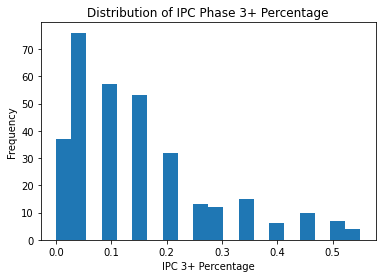

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(ipc_pivot['target_ipc3plus_pct'], bins=20)
plt.title("Distribution of IPC Phase 3+ Percentage")
plt.xlabel("IPC 3+ Percentage")
plt.ylabel("Frequency")
plt.show()

### Crisis vs Non-Crisis Bar Chart
`This confirms your 79% vs 21% imbalance visually.`

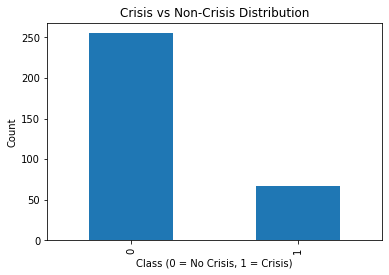

In [7]:
plt.figure()
ipc_pivot['target_crisis_binary'].value_counts().plot(kind='bar')
plt.title("Crisis vs Non-Crisis Distribution")
plt.xlabel("Class (0 = No Crisis, 1 = Crisis)")
plt.ylabel("Count")
plt.show()

### Trend Over Time

`Drought spikes`

`Recovery periods`

`Long-term trends`

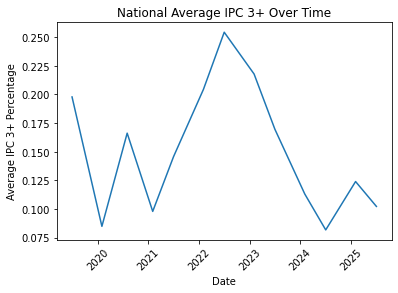

In [8]:
ipc_trend = ipc_pivot.groupby('From')['target_ipc3plus_pct'].mean()

plt.figure()
plt.plot(ipc_trend.index, ipc_trend.values)
plt.title("National Average IPC 3+ Over Time")
plt.xlabel("Date")
plt.ylabel("Average IPC 3+ Percentage")
plt.xticks(rotation=45)
plt.show()

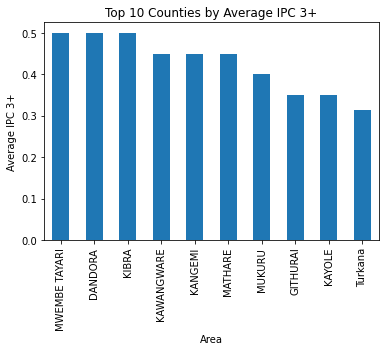

In [9]:
top_counties = (
    ipc_pivot.groupby('Area')['target_ipc3plus_pct']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
top_counties.plot(kind='bar')
plt.title("Top 10 Counties by Average IPC 3+")
plt.ylabel("Average IPC 3+")
plt.show()

In [10]:
print(ipc_pivot.shape)
print(ipc_pivot['Area'].nunique())
print(ipc_pivot['From'].min(), "to", ipc_pivot['From'].max())

(322, 11)
53
2019-07-01 00:00:00 to 2025-07-01 00:00:00


In [11]:
rain.head()

,date,adm_level,adm_id,PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,1981-01-01,1,51325,KE019,427.0,7.372365,15.759407,NaN,NaN,NaN,NaN,59.598840,NaN,NaN,final
1,1981-01-11,1,51325,KE019,427.0,4.325527,19.294770,NaN,NaN,NaN,NaN,38.384920,NaN,NaN,final
2,1981-01-21,1,51325,KE019,427.0,5.569087,16.265417,17.266980,51.319595,NaN,NaN,49.700817,39.536823,NaN,final
3,1981-02-01,1,51325,KE019,427.0,5.882904,12.719282,15.777517,48.279470,NaN,NaN,61.418427,38.997230,NaN,final
4,1981-02-11,1,51325,KE019,427.0,17.180328,18.768618,28.632318,47.753320,NaN,NaN,93.317700,63.753933,NaN,final


In [12]:
print(rain.head())
print(rain.columns)
print(rain.shape)

         date  adm_level  adm_id  PCODE  n_pixels        rfh    rfh_avg  \
0  1981-01-01          1   51325  KE019     427.0   7.372365  15.759407   
1  1981-01-11          1   51325  KE019     427.0   4.325527  19.294770   
2  1981-01-21          1   51325  KE019     427.0   5.569087  16.265417   
3  1981-02-01          1   51325  KE019     427.0   5.882904  12.719282   
4  1981-02-11          1   51325  KE019     427.0  17.180328  18.768618   

         r1h    r1h_avg  r3h  r3h_avg        rfq        r1q  r3q version  
0        NaN        NaN  NaN      NaN  59.598840        NaN  NaN   final  
1        NaN        NaN  NaN      NaN  38.384920        NaN  NaN   final  
2  17.266980  51.319595  NaN      NaN  49.700817  39.536823  NaN   final  
3  15.777517  48.279470  NaN      NaN  61.418427  38.997230  NaN   final  
4  28.632318  47.753320  NaN      NaN  93.317700  63.753933  NaN   final  
Index(['date', 'adm_level', 'adm_id', 'PCODE', 'n_pixels', 'rfh', 'rfh_avg',
       'r1h', 'r1h_avg

### 1. converting to monthly Rainfall

In [13]:
# Convert date
rain['date'] = pd.to_datetime(rain['date'])

# Convert to monthly timestamp
rain['From'] = rain['date'].dt.to_period('M').dt.to_timestamp()

# Aggregate to monthly rainfall per PCODE
rain_monthly = (
    rain.groupby(['PCODE', 'From'])['rfh']
    .sum()
    .reset_index()
)

rain_monthly.rename(columns={'rfh': 'rain_mm'}, inplace=True)

print(rain_monthly.head())

      PCODE       From  rain_mm
0  KE001003 1981-01-01     32.0
1  KE001003 1981-02-01      7.2
2  KE001003 1981-03-01    166.4
3  KE001003 1981-04-01     96.8
4  KE001003 1981-05-01    153.1


### 2. Restrict to IPC Date Range
`ipc ranges from 2019-07 to 2025-07`

In [14]:
rain_monthly = rain_monthly[
    (rain_monthly['From'] >= ipc_pivot['From'].min()) &
    (rain_monthly['From'] <= ipc_pivot['From'].max())
]

### 3. Map PCODE → County Name

In [15]:
rain_monthly.head()

,PCODE,From,rain_mm
462,KE001003,2019-07-01,103.7
463,KE001003,2019-08-01,80.3
464,KE001003,2019-09-01,88.4
465,KE001003,2019-10-01,442.9
466,KE001003,2019-11-01,184.1


In [16]:
mpi.head()

,Country ISO3,Admin 1 PCode,Admin 1 Name,MPI,Headcount Ratio,Intensity of Deprivation,Vulnerable to Poverty,In Severe Poverty,Survey,Start Date,End Date
0,#country+code,#adm1+code,#adm1+name,#indicator+mpi,#indicator+headcount_ratio,#indicator+intensity_of_deprivation,#indicator+vulnerable_to_poverty,#indicator+in_severe_poverty,#meta+survey,#date+start,#date+end
1,KEN,NaN,NaN,0.1134,25.3523,44.7108,26.4044,7.4594,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
2,KEN,KE001,Mombasa,0.0518,12.8866,40.2193,16.8930,2.2801,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
3,KEN,KE002,Kwale,0.2105,44.5123,47.2996,27.2794,17.2902,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
4,KEN,KE003,Kilifi,0.2026,46.3581,43.7119,23.8772,13.1869,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00


In [17]:
print(rain_monthly['PCODE'].nunique())

81


In [18]:
conflict.head()

,Licensing
0,By using ACLED data you agree to abide by the ...
1,https://acleddata.com/terms-of-use/
2,NaN
3,Terms of Use
4,All rights to use or exploit ACLED data or ana...


In [19]:
mpi.head()

,Country ISO3,Admin 1 PCode,Admin 1 Name,MPI,Headcount Ratio,Intensity of Deprivation,Vulnerable to Poverty,In Severe Poverty,Survey,Start Date,End Date
0,#country+code,#adm1+code,#adm1+name,#indicator+mpi,#indicator+headcount_ratio,#indicator+intensity_of_deprivation,#indicator+vulnerable_to_poverty,#indicator+in_severe_poverty,#meta+survey,#date+start,#date+end
1,KEN,NaN,NaN,0.1134,25.3523,44.7108,26.4044,7.4594,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
2,KEN,KE001,Mombasa,0.0518,12.8866,40.2193,16.8930,2.2801,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
3,KEN,KE002,Kwale,0.2105,44.5123,47.2996,27.2794,17.2902,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00
4,KEN,KE003,Kilifi,0.2026,46.3581,43.7119,23.8772,13.1869,DHS,2022-01-01 00:00:00+00:00,2022-12-31 23:59:59+00:00


In [20]:
prices.head()

,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize,51,KG,actual,Wholesale,KES,16.13,0.22
2,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,cereals and tubers,Maize (white),67,90 KG,actual,Wholesale,KES,1480,20.58
3,2006-01-15,Coast,Mombasa,Mombasa,191,-4.05,39.67,pulses and nuts,Beans,50,KG,actual,Wholesale,KES,33.63,0.47
4,2006-01-15,Eastern,Kitui,Kitui,187,-1.37,38.02,cereals and tubers,Maize (white),67,KG,actual,Retail,KES,17,0.24
